# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

In [1]:
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
DEFAULT_FIGSIZE = [15, 3]

plt.rc('figure', figsize=DEFAULT_FIGSIZE)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 12)

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12
The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file.

In [3]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and math.isnan(date_str):
            return np.nan
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        'data/webis-smc-12.txt',
        sep='\t',
        lineterminator='\n',
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=['TimeStamp'],
        date_parser=date_parser)

    df.drop(columns=['MissionID', 'Comment'], inplace=True)
    
    df.rename(
        columns={
            'UserID': 'user_id',
            'Query': 'query',
            'TimeStamp': 'timestamp',
            'ClickRank': 'click_rank',
            'ClickDomain': 'click_url'
        },
        inplace=True)
    
    df.click_rank = df.click_rank.astype(pd.Int64Dtype())

    return df

# Dataset loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12

In [4]:
qlog = load_webis_smc_12('data/webis-smc-12.txt'); qlog

,user_id,query,timestamp,click_rank,click_url
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org
4,38534,goody,2006-03-20 16:19:46,NaN,NaN
5,38534,goody,2006-03-20 16:19:47,NaN,NaN
...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN


# Query-level analysis

- Number of queries / interactions
- Number of distinct queries
- Distribution of number of queries / interactions per user
- Distribution of queries / interactions over time
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Total number of queries and distinct queries

In [5]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], len(qlog['query'].unique())],
    columns=['value'],
    index=['num_queries', 'num_distinct_queries'])
qlevel_stats

,value
num_queries,8838
num_distinct_queries,3736


## Distribution of number of queries per user

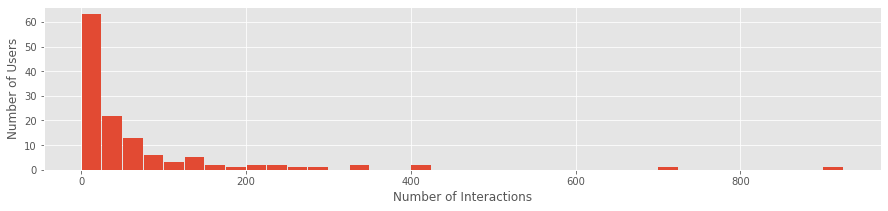

In [6]:
queries_per_user = qlog[['user_id', 'query']] \
    .groupby(['user_id']) \
    .count()

d_min = queries_per_user['query'].min()
d_max = queries_per_user['query'].max()
bin_width = 25

queries_per_user \
    .plot(kind='hist', bins=range(0, d_max+bin_width, bin_width), rwidth=.95, legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

## Distribution of queries over time

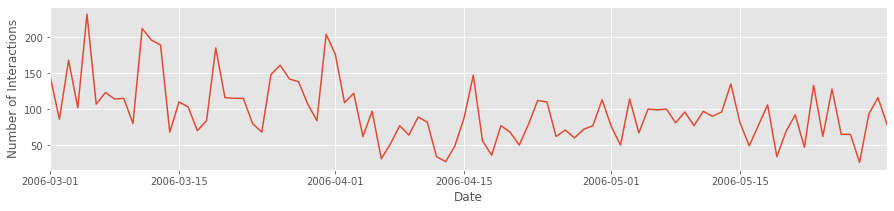

In [7]:
qlog['date'] = qlog['timestamp'].map(lambda t: t.date())

qlog \
    .groupby(['date']) \
    .size() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

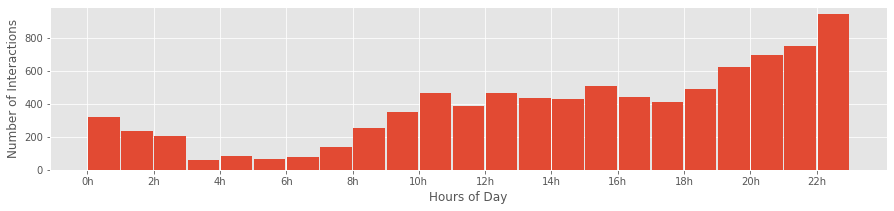

In [8]:
qlog['timestamp'].map(lambda t: t.hour) \
    .plot(kind='hist', bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)])
plt.xlabel('Hours of Day')
plt.ylabel('Number of Interactions')
plt.show()

### Per weekday cycles

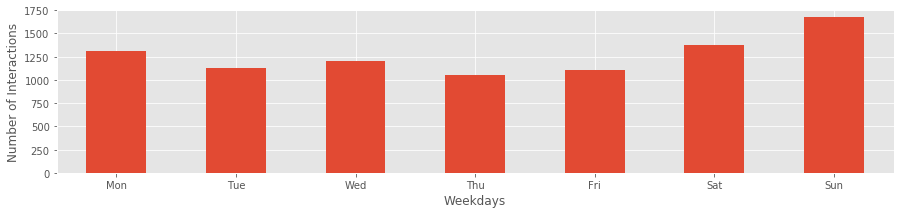

In [9]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

qlog['weekday'] = qlog['timestamp'].map(lambda t: t.weekday())

qlog \
    .groupby(['weekday']) \
    .size() \
    .plot(kind='bar')

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel('Weekdays')
plt.ylabel('Number of Interactions')
plt.show()

### Per monthly cycles

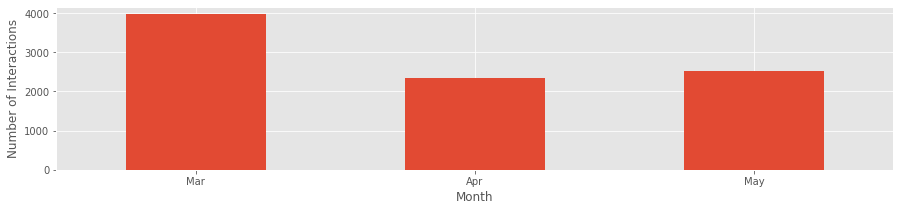

In [10]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
qlog['month'] = qlog['timestamp'].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(['month']) \
    .size() \

queries_per_month \
    .plot(kind='bar')

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.show()

# Topic-level analysis

In [11]:
#qlog['topic'] = 'topics'
#bbc datasets

# Session-level analysis

- Number of queries / interactions per session
- Number of distinct queries per session
- Session duration distribution
- Distribution of number of clicks per session (boxplot)
- Average clicked rank per session duration


- Average session duration:
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

**Note:** Don't run the following code block if there is already a "session_id" column.

In [107]:
from datetime import timedelta

def detect_sessions(qlog, mins=30):
    qlog.drop('session_id', axis=1, errors='ignore', inplace=True)
    new_sessions = pd.Series([], dtype='int64')
    for _, user_qlog in qlog.sort_values(by=['user_id', 'timestamp']).groupby('user_id'):
        user_new_sessions = user_qlog.timestamp.gt(user_qlog.timestamp.shift() + timedelta(minutes=mins))
        user_new_sessions.iloc[0] = True
        new_sessions = new_sessions.append(user_new_sessions)
    return pd.concat([
        qlog.sort_values(by=['user_id', 'timestamp']),
        pd.DataFrame({ 'session_id': new_sessions.cumsum() + 1 })
    ], axis=1, sort=False)

qlog = detect_sessions(qlog); qlog

,user_id,query,timestamp,click_rank,click_url,date,weekday,month,person,organization,place,session_id
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,2,3,None,[police],[maryland],2
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,2,3,None,None,None,2
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,2,3,None,"[police, aberdeen]","[maryland, aberdeen]",2
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,2,3,None,"[police, aberdeen]","[maryland, aberdeen]",2
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,0,3,None,None,None,3
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,0,3,None,None,None,3
...,...,...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,0,5,None,None,None,2547
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,0,5,None,None,None,2547
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,0,5,None,None,None,2547


## Number of interactions per session

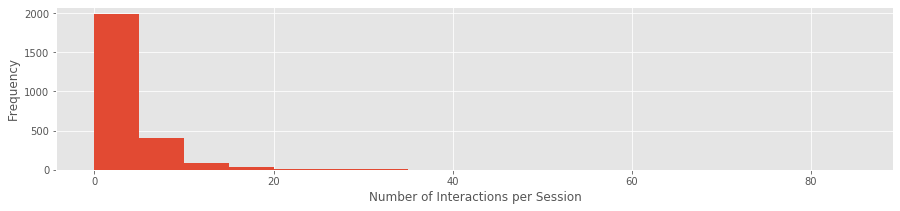

In [141]:
queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .count()

d_min = queries_per_session['query'].min()
d_max = queries_per_session['query'].max()
bin_width = 5

queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

## Number of distinct queries per session

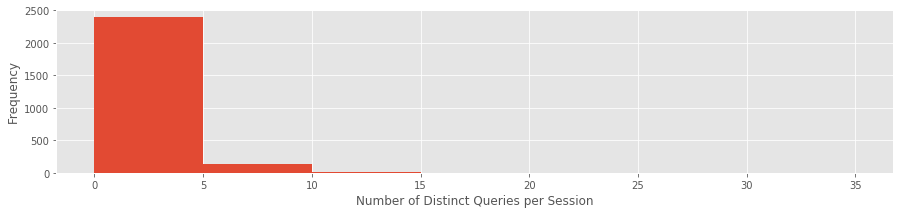

In [109]:
distinct_queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .nunique()

distinct_queries_per_session['session_id'] = distinct_queries_per_session.index
distinct_queries_per_session.drop('session_id', axis=1, inplace=True)
distinct_queries_per_session = distinct_queries_per_session.reset_index().drop('session_id', axis=1)

d_min = distinct_queries_per_session['query'].min()
d_max = distinct_queries_per_session['query'].max()
bin_width = 5

distinct_queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Distinct Queries per Session")
plt.ylabel("Frequency")
plt.show()

## Session duration distribution

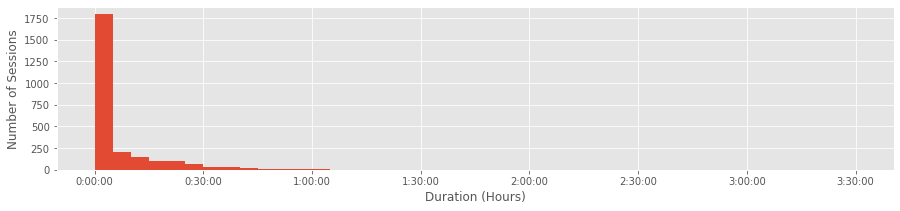

In [143]:
from matplotlib.ticker import FuncFormatter

session_durations = qlog[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1)

d_min = session_durations['duration'].min()
d_max = session_durations['duration'].max()
bin_width = 5/60

ax = session_durations \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: timedelta(seconds=x * 3600)))
plt.xlabel("Duration (Hours)")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of number of clicks per session

## Average clicked rank per session duration

# Term-level analysis

In [16]:
#qlog['length'] = 'query_chars'
#qlog['num_words'] = 'query_words'

# Entity-level analysis

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia `rdfs:label` for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

In [17]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor
ac = {
    'person': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_person.txt'),
    'organization': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_organization.txt'),
    'place': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_place.txt')
}

In [18]:
from collections import OrderedDict
from functools import reduce

for d_class in ac.keys():
    qlog[d_class] = None

    for i in range(len(qlog)):
        query = qlog.loc[i, 'query']
        entities = ac[d_class].extract(query)
        
        for entity in entities:
            if qlog.loc[i, d_class] is None:
                qlog.at[i, d_class] = [entity]
            else:
                qlog.at[i, d_class].append(entity)

qlog

,user_id,query,timestamp,click_rank,click_url,date,weekday,month,session_id,person,organization,place
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,2,3,1,None,[police],[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,2,3,1,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,2,3,1,None,"[police, aberdeen]","[maryland, aberdeen]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,2,3,1,None,"[police, aberdeen]","[maryland, aberdeen]"
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,0,3,2,None,None,None
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,0,3,2,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,0,5,2420,None,None,None
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,0,5,2420,None,None,None
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,0,5,2420,None,None,None


In [19]:
import itertools

qlog_entities = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    entity_count = pd.DataFrame({
            'entity': list(itertools.chain(*filter(lambda d: d is not None, qlog[d_class]))),
            'class': d_class
        }) \
        .groupby(['entity', 'class']) \
        .size() \
        .reset_index() \
        .rename({0: 'count'}, axis='columns')
    
    qlog_entities = qlog_entities.append(entity_count)

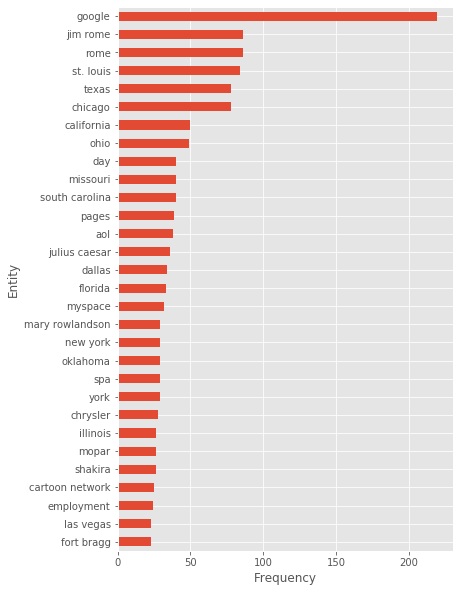

In [20]:
plt.rc('figure', figsize=[6, 10])

qlog_entities[['entity', 'count']] \
    .groupby('entity') \
    .sum() \
    .reset_index() \
    .sort_values(by='count', ascending=False) \
    .head(30) \
    .plot(kind='barh', x='entity', y='count', legend=False)

plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

In [21]:
def plot_entities_by_class(qlog_entities, d_class):
    plt.rc('figure', figsize=[6, 10])

    qlog_entities[qlog_entities['class'] == d_class] \
        .sort_values(by='count', ascending=False) \
        .head(30) \
        .plot(kind='barh', x='entity', y='count', legend=False)

    plt.xlabel('Frequency')
    plt.ylabel(d_class.title())
    plt.gca().invert_yaxis()
    plt.show()

    plt.rc('figure', figsize=DEFAULT_FIGSIZE)

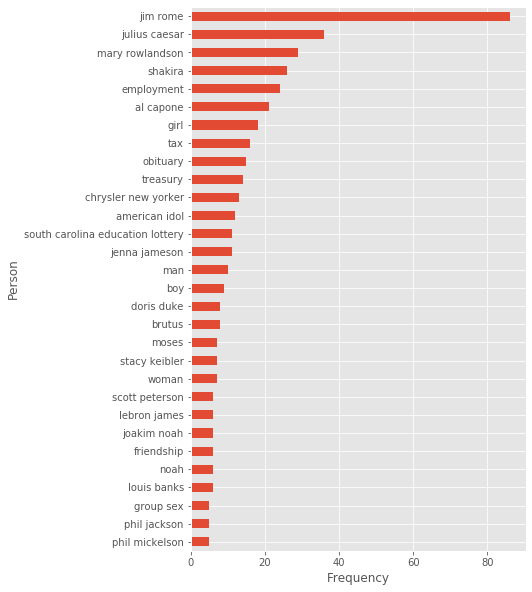

In [22]:
plot_entities_by_class(qlog_entities, 'person')

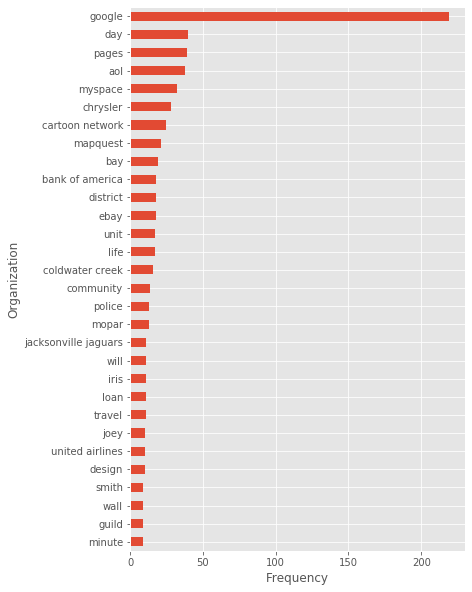

In [23]:
plot_entities_by_class(qlog_entities, 'organization')

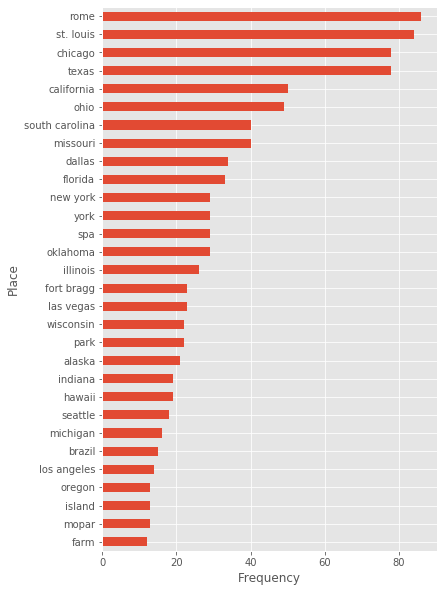

In [24]:
plot_entities_by_class(qlog_entities, 'place')

## Entity-query-level analysis

## Entity-topic-level analysis

## Entity-session-level analysis

- Grafo de entidades numa sessão
  - Distâncias

## Entity-term-level analysis

## Entity-entity-level analysis